# Whole Slide Image sampler module:

****
## Testing with:
```python
tensorflow==2.0.0rc0
```

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
# tf.enable_eager_execution()  # tf 2.0 no need

import os

import time
import glob
import math
import multiprocessing as mp
import itertools
import hashlib
import tempfile

import numpy as np
import openslide
from skimage.filters import threshold_otsu

import PIL

import IPython.display as display

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def image_example(image_string, label):
    """ image_metadat_dict = image_example(image_string, label)
    Create a dictionary of jpg image features
    """
    image_shape = tf.image.decode_jpeg(image_string).shape

    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

def raw_jpg_to_tfrecord(image_labels_dict, file_name='slide_images.tfrecords'):
    """ raw_jpg_to_tfrecord(image_labels_dict, file_name)
    write a jpg image to to a tfrecord
    """
    with tf.io.TFRecordWriter(file_name) as writer:
        for filename, label in image_labels_dict.items():
            image_string = open(filename, 'rb').read()
            tf_example = image_example(image_string, label)
            writer.write(tf_example.SerializeToString())

In [2]:
import os
import numpy as np
def get_adjcent_segmented_length_fence_array(segment_length, length):
    """
    """
    fences = {}
    n_fenced = length // segment_length
    n_remain = 1 + length % segment_length
    paddit = n_remain // 2
    if n_remain == segment_length:
        paddit = 0
        n_remain = 0
        n_fenced = n_fenced + 1
    
    fence_array = np.zeros((n_fenced, 2)).astype(int)
    for k in range(n_fenced):
        if k == 0:
            fence_array[k, 0] = paddit
            fence_array[k, 1] = fence_array[k, 0] + segment_length - 1
        elif fence_array[k-1, 1] + segment_length <= length:
            fence_array[k, 0] = fence_array[k-1, 1] + 1
            fence_array[k, 1] = fence_array[k, 0] + segment_length - 1
        
    fences['fence_array'] = fence_array
    fences['n_fenced'] = n_fenced
    fences['n_remain'] = n_remain
    fences['padding'] = paddit

    return fences

def test_fence_array_function():
    segment_length = 224
    length = segment_length*4 - 3

    print('\tget_adjcent_segmented_length_fence_array')
    print('\tn pixels: %i patch_length: %i\n'%(length, segment_length))
    fences_dict = get_adjcent_segmented_length_fence_array(segment_length, length)
    for k, v in fences_dict.items():
        if isinstance(v, np.ndarray):
            print('%20s:'%(k))
            for v_idx in range(v.shape[0]):
                if v[v_idx,1] - v[v_idx,0] != segment_length - 1:
                    print('%24s, %6i   Bug Bug'%(v[v_idx,0], v[v_idx,1]))
                else:
                    print('%24s, %6i'%(v[v_idx,0], v[v_idx,1]))
        else:
            print('%20s: %s'%(k,v))

        
def get_patch_name_from_row_col(row, col, base_name='patch', file_ext='.jpg'):
    """ patch_name = get_patch_name_from_row_col(row, col, base_name='patch', 
                                                file_ext='.jpg') 
                                                """
    if file_ext[0] != '.':
        file_ext = '.' + file_ext
    patch_name = base_name + '_row_%i_%i'%(row[0], row[1])
    patch_name += '_col_%i_%i%s'%(col[0], col[1], file_ext)
    
    return patch_name

def get_row_col_from_patch_name(fname):
    """ row_col_dict = get_row_col_from_filename(fname) 
    """
    row_label = 'row'
    col_label = 'col'
    r = []
    c = []
    base_name, file_ext = os.path.splitext(os.path.split(fname)[1])
    parts_list = base_name.split('_')
    
    for i in range(len(parts_list)):
        if parts_list[i] == row_label:
            r.append(parts_list[i+1])
            r.append(parts_list[i+2])
        elif parts_list[i] == col_label:
            c.append(parts_list[i+1])
            c.append(parts_list[i+2])
    row = np.array(r).astype(np.int)
    col = np.array(c).astype(np.int)
    return {'base_name': parts_list[0], 'file_ext': file_ext, 'row': row, 'col': col }

def test_patch_names(out_test_dir):
    """
    """
    jpg_list = []
    for f in os.listdir(out_test_dir):
        _, f_ext = os.path.splitext(f)
        if f_ext == '.jpg':
            full_name = os.path.join(out_test_dir, f)
            if full_name in jpg_list:
                print('duplicate name: ???', full_name)
            else:
                jpg_list.append(full_name)

    n = 5
    for n in np.random.randint(0,999,5):
        _, one_name = os.path.split(jpg_list[n])
        print(one_name)
        rc_dict = get_row_col_from_patch_name(fname=jpg_list[n])

        bname = get_patch_name_from_row_col(rc_dict['row'],
                                            rc_dict['col'],
                                            rc_dict['base_name'],
                                            rc_dict['file_ext'])
        print(bname)
        print(rc_dict['row'], rc_dict['col'])
        print(rc_dict['base_name'], '\t\t', rc_dict['file_ext'], '\n')
        
print('test_fence_array_function')
test_fence_array_function()
out_test_dir = '../../DigiPath_MLTK_data/out_to_test'
print('\n\ntest_patch_names')
test_patch_names(out_test_dir)

test_fence_array_function
	get_adjcent_segmented_length_fence_array
	n pixels: 893 patch_length: 224

         fence_array:
                     111,    334
                     335,    558
                     559,    782
            n_fenced: 3
            n_remain: 222
             padding: 111


test_patch_names
CMU-1_row_8104_8327_col_32361_32584.jpg
CMU-1_row_8104_8327_col_32361_32584.jpg
[8104 8327] [32361 32584]
CMU-1 		 .jpg 

CMU-1_row_4744_4967_col_28329_28552.jpg
CMU-1_row_4744_4967_col_28329_28552.jpg
[4744 4967] [28329 28552]
CMU-1 		 .jpg 

CMU-1_row_7432_7655_col_31913_32136.jpg
CMU-1_row_7432_7655_col_31913_32136.jpg
[7432 7655] [31913 32136]
CMU-1 		 .jpg 

CMU-1_row_4744_4967_col_31465_31688.jpg
CMU-1_row_4744_4967_col_31465_31688.jpg
[4744 4967] [31465 31688]
CMU-1 		 .jpg 

CMU-1_row_11016_11239_col_31017_31240.jpg
CMU-1_row_11016_11239_col_31017_31240.jpg
[11016 11239] [31017 31240]
CMU-1 		 .jpg 



               output patch images size::   224,   224
output directory:
	 /Users/yo/git_clone/ncsa_genomics/DigiPath_MLTK_data/out_to_test
Opening Image file: 
	../../DigiPath_MLTK_data/Aperio/CMU-1.svs



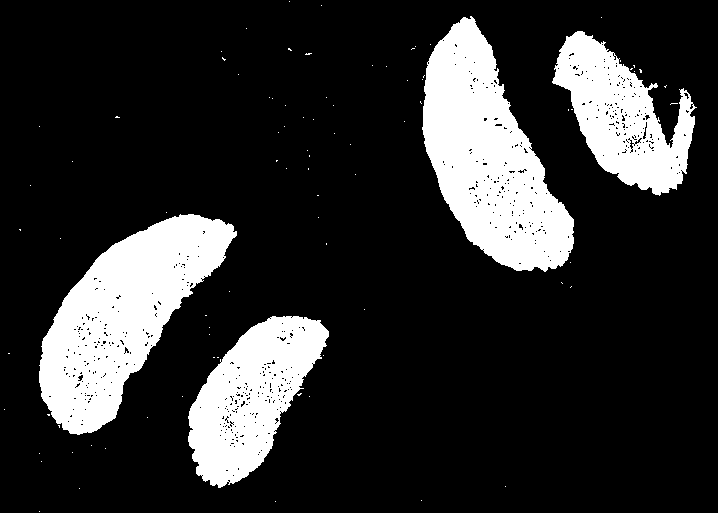

In [4]:
import openslide
from skimage.filters import threshold_otsu

import PIL

def get_thumbnail_mask_from_OpenSlide_obj(os_obj):
    """ mask_im = get_thumbnail_mask_from_OpenSlide_obj(os_obj)
    """
    pixels_height_ds = os_obj.level_dimensions[-1][0]
    pixels_width_ds = os_obj.level_dimensions[-1][1]

    im_thumb = os_obj.get_thumbnail((pixels_height_ds//4, pixels_width_ds//4))
    im_thumb = np.array(im_thumb.convert('L'))
    thresh = threshold_otsu(im_thumb)
    mask = np.array(im_thumb) < thresh
    mask_im = PIL.Image.fromarray(np.uint8(mask) * 255)
    
    return mask_im

data_dir = '../../DigiPath_MLTK_data/Aperio'
files_list = ['CMU-1-Small-Region.svs', 'CMU-1.svs']

PATCH_HEIGHT = 224
PATCH_WIDTH = 224
print('%40s: %5i, %5i'%('output patch images size:',PATCH_HEIGHT, PATCH_WIDTH))
target_dir = '../../DigiPath_MLTK_data/out_to_test'
print('output directory:\n\t', os.path.abspath(target_dir))

#                                               open the file
test_file_name = os.path.join(data_dir, 'CMU-1.svs')
print('Opening Image file: \n\t{}\n'.format(test_file_name))
os_obj = openslide.OpenSlide(test_file_name)
pixels_height = os_obj.dimensions[0]
pixels_width = os_obj.dimensions[1]

mask_im = get_thumbnail_mask_from_OpenSlide_obj(os_obj)

display(mask_im)

In [ ]:
# def svs_to_tfrecord_of_patches(svs_file_name, patch_size)

## working script 
```python
"""                           Timing test - write 1000 patch files           """
walk_start_time = time.time()

_, file_name_base = os.path.split(test_file_name)
file_name_base, _ = os.path.splitext(file_name_base)
file_ext = '.jpg'
print('file_name_base', file_name_base, '\nfile extension', file_ext)

keeper_threshold = 0.5
patch_size =(PATCH_WIDTH, PATCH_HEIGHT)
row_fence_array = full_rows['fence_array']
col_fence_array = full_cols['fence_array']
keepers = 0
skippers = 0
time_req_to_open_and_save = 0
n_opened = 0
n_to_open = 1000
for row in range(row_fence_array.shape[0]):
    if row % 10 == 0:
        print('row %3i: %03f'%(row, time.time() - walk_start_time))
        
    for col in range(col_fence_array.shape[0]):
        r = row_fence_array[row]*row_scale_down
        c = col_fence_array[col]*col_scale_down
        area = (c[0], r[0], c[1], r[1])
        thumb_segment = mask_im.crop(area)
        thumb_arr = np.array(thumb_segment)
        mask_value = np.float(np.sum(thumb_arr==0)) / np.float(np.prod(thumb_arr.shape))
        if mask_value > keeper_threshold:
            skippers += 1
        else:
            keepers += 1
            
            if n_to_open > 1:
                n_to_open -= 1
                t0 = time.time()
                rc_location = (col_fence_array[col][0], row_fence_array[row][0])
                full_sect = os_obj.read_region(level=0, size=patch_size, 
                                               location=rc_location)
                
                time_scale = 1e32
                t_int = b'%i'%np.int(t0 * time_scale)
                m = hashlib.sha1()
                m.update(t_int)
                
                small_name = file_name_base + '_row_%i_%i'%(row_fence_array[row][0], 
                                                            row_fence_array[row][1])
                small_name += '_col_%i_%i%s'%(col_fence_array[col][0], 
                                              col_fence_array[col][1], file_ext)
                full_sect = full_sect.convert('RGB')
                
                small_name = os.path.join(output_dir, small_name)
                full_sect.save(small_name)
                
                time_req_to_open_and_save += time.time() - t0
                n_opened += 1
                
average_time_req_to_open_and_save = time_req_to_open_and_save / n_opened
print('tt = %0.3f\nkeepers = %i\nskippers = %i'%(time.time() - walk_start_time, 
                                                 keepers, skippers))
print('average open & write time: %0.3f'%(average_time_req_to_open_and_save))
print('estimated total time: %0.2f'%(keepers*average_time_req_to_open_and_save))
```